## Low-Rank Autoregressive Tensor Completion Imputer (LATC-imputer)

This notebook shows how to implement a LATC imputer on some real-world data sets (e.g., PeMS traffic speed data, Guangzhou traffic speed data). To overcome the problem of missing values within multivariate time series data, this method takes into account both low-rank structure and time series regression. For an in-depth discussion of LATC-imputer, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Author Name (2020). <b>Low-Rank Autorgressive Tensor Completion for Multivariate Time Series Forecasting</b>. arXiv.2006. <a href="xx" title="PDF"><b>[PDF]</b></a> 
</font>
</div>


In [1]:
import numpy as np
from numpy.linalg import inv as inv
import matplotlib.pyplot as plt

%matplotlib inline

### Define LATC-imputer kernel

We start by introducing some necessary functions that relies on `Numpy`.

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>ten2mat</code>:</b> <font color="black">Unfold tensor as matrix by specifying mode.</font></li>
<li><b><code>mat2ten</code>:</b> <font color="black">Fold matrix as tensor by specifying dimension (i.e, tensor size) and mode.</font></li>
<li><b><code>svt</code>:</b> <font color="black">Implement the process of Singular Value Thresholding (SVT).</font></li>
</ul>
</div>

In [2]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def mat2ten(mat, dim, mode):
    index = list()
    index.append(mode)
    for i in range(dim.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(dim[index]), order = 'F'), 0, mode)

In [3]:
def svt_tsn(Z, alpha, rho, p, theta, s0):
    u, s, v = np.linalg.svd(Z, full_matrices = 0)
    vec = s.copy()
    vec[theta :] = s[theta :] - alpha / rho * p * np.power(s0[theta :], p - 1)
    vec[vec < 0] = 0
    return u @ np.diag(vec) @ v, s

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>compute_mape</code>:</b> <font color="black">Compute the value of Mean Absolute Percentage Error (MAPE).</font></li>
<li><b><code>compute_rmse</code>:</b> <font color="black">Compute the value of Root Mean Square Error (RMSE).</font></li>
</ul>
</div>

> Note that $$\mathrm{MAPE}=\frac{1}{n} \sum_{i=1}^{n} \frac{\left|y_{i}-\hat{y}_{i}\right|}{y_{i}} \times 100, \quad\mathrm{RMSE}=\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}},$$ where $n$ is the total number of estimated values, and $y_i$ and $\hat{y}_i$ are the actual value and its estimation, respectively.

In [4]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

The main idea behind LATC-imputer is to approximate partially observed data with both low-rank structure and time series dynamics. The following `imputer` kernel includes some necessary inputs:

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>dense_tensor</code>:</b> <font color="black">This is an input which has the ground truth for validation. If this input is not available, you could use <code>dense_tensor = sparse_tensor.copy()</code> instead.</font></li>
<li><b><code>sparse_tensor</code>:</b> <font color="black">This is a partially observed tensor which has many missing entries.</font></li>
<li><b><code>time_lags</code>:</b> <font color="black">Time lags, e.g., <code>time_lags = np.array([1, 2, 3])</code>. </font></li>
<li><b><code>alpha</code>:</b> <font color="black">Weights for tensors' nuclear norm, e.g., <code>alpha = np.ones(3) / 3</code>. </font></li>
<li><b><code>rho</code>:</b> <font color="black">Learning rate for ADMM, e.g., <code>rho = 0.0005</code>. </font></li>
<li><b><code>lambda0</code>:</b> <font color="black">Weight for time series regressor, e.g., <code>lambda0 = 5 * rho</code>. If <code>lambda0 = 0</code>, then this imputer is actually a standard low-rank tensor completion (i.e., High-accuracy Low-Rank Tensor Completion, or HaLRTC).</font></li>
<li><b><code>epsilon</code>:</b> <font color="black">Stop criteria, e.g., <code>epsilon = 0.001</code>. </font></li>
<li><b><code>maxiter</code>:</b> <font color="black">Maximum iteration to stop algorithm, e.g., <code>maxiter = 50</code>. </font></li>
</ul>
</div>


In [5]:
def imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho0, lambda0, p, theta, epsilon, maxiter):
    """Low-Rank Autoregressive Tensor Completion, LATC-imputer."""
    dim = np.array(sparse_tensor.shape)
    dim_time = np.int(np.prod(dim) / dim[0])
    d = len(time_lags)
    max_lag = np.max(time_lags)
    sparse_mat = ten2mat(sparse_tensor, 0)
    pos_missing = np.where(sparse_mat == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    
    X = np.zeros(np.insert(dim, 0, len(dim))) # \boldsymbol{\mathcal{X}}
    T = np.zeros(np.insert(dim, 0, len(dim))) # \boldsymbol{\mathcal{T}}
    Z = sparse_mat.copy()                     # \boldsymbol{Z}
    Z[pos_missing] = np.mean(sparse_mat[sparse_mat != 0])
    A = 0.001 * np.random.rand(dim[0], d)     # \boldsymbol{A}
    it = 0
    ind = np.zeros((d, dim_time - max_lag), dtype = np.int_)
    for i in range(d):
        ind[i, :] = np.arange(max_lag - time_lags[i], dim_time - time_lags[i])
    last_mat = sparse_mat.copy()
    s = []
    for k in range(len(dim)):
        u, s0, v = np.linalg.svd(ten2mat(mat2ten(Z, dim, 0), k), full_matrices = 0)
        s.append(s0)
    snorm = np.linalg.norm(sparse_mat, 'fro')
    rho = rho0
    while True:
        rho = min(rho * 1.05, 1e5)
        for k in range(len(dim)):
            temp1, temp2 = svt_tsn(ten2mat(mat2ten(Z, dim, 0) - T[k] / rho, k), alpha[k], rho, p, theta, s[k])
            X[k] = mat2ten(temp1, dim, k)
            s[k] = temp2
        tensor_hat = np.einsum('k, kmnt -> mnt', alpha, X)
        mat_hat = ten2mat(tensor_hat, 0)
        mat0 = np.zeros((dim[0], dim_time - max_lag))
        if lambda0 > 0:
            for m in range(dim[0]):
                Qm = mat_hat[m, ind].T
                A[m, :] = np.linalg.pinv(Qm) @ Z[m, max_lag :]
                mat0[m, :] = Qm @ A[m, :]
            mat1 = ten2mat(np.mean(rho * X + T, axis = 0), 0)
            Z[pos_missing] = np.append((mat1[:, : max_lag] / rho), (mat1[:, max_lag :] + lambda0 * mat0) 
                                       / (rho + lambda0), axis = 1)[pos_missing]
        else:
            Z[pos_missing] = (ten2mat(np.mean(X + T / rho, axis = 0), 0))[pos_missing]
        T = T + rho * (X - np.broadcast_to(mat2ten(Z, dim, 0), np.insert(dim, 0, len(dim))))
        tol = np.linalg.norm((mat_hat - last_mat), 'fro') / snorm
        last_mat = mat_hat.copy()
        it += 1
        if it % 100 == 0:
            print('Iter: {}'.format(it))
            print('Tolerance: {:.6}'.format(tol))
            print('MAPE: {:.6}'.format(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test])))
            print('RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test])))
            print()
        if (tol < epsilon) or (it >= maxiter):
            break

    print('Total iteration: {}'.format(it))
    print('Tolerance: {:.6}'.format(tol))
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test])))
    print()
    
    return tensor_hat

If you want to set parameters reasonably, please use this cross validation on your data set.

In [6]:
def imputer_validation(tensor, validation_rate, num_fold):
    dim = tensor.shape
    random_data = np.random.rand(dim[0], dim[1], dim[2])
    random_data[tensor == 0] = 0
    train_data = []
    validation_data = []
    for i in range(num_fold):
        temp1 = np.zeros(tensor.shape)
        pos = np.where((i * validation_rate < random_data) & (random_data <= (i + 1) * validation_rate))
        temp1[pos] = tensor[pos]
        train_data.append(temp1)
        
        temp2 = np.zeros(tensor.shape)
        pos = np.where((random_data <= i * validation_rate) | (random_data > (i + 1) * validation_rate))
        temp2[pos] = tensor[pos]
        validation_data.append(temp2)
    return train_data, validation_data

def cross_validation(train_data, validation_data, num_fold, lambdas, thetas,
                     time_lags, alpha, rho, epsilon, maxiter):
    result = np.zeros((lambdas.shape[0], thetas.shape[0], 2))
    for lam in range(lambdas.shape[0]):
        for theta in range(thetas.shape[0]):
            mape0 = 0
            rmse0 = 0
            for i in range(num_fold):
                dense_tensor = train_data[i] + validation_data[i]
                sparse_tensor = validation_data[i]
                tensor_hat, mape, rmse = imputer(dense_tensor, sparse_tensor, 
                                                 time_lags, alpha, rho, lambdas[lam], 
                                                 epsilon, maxiter, thetas[theta])
                mape0 += mape
                rmse0 += rmse
            result[lam, theta, 0] = mape0 / num_fold
            result[lam, theta, 1] = rmse0 / num_fold
    return result

### Guangzhou data

We generate **random missing (RM)** values on Guangzhou traffic speed data set.

In [6]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
dense_tensor = tensor['tensor']
random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

missing_rate = 0.4

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = np.transpose(dense_tensor, [0, 2, 1])
sparse_tensor = np.transpose(sparse_tensor, [0, 2, 1])

We use `imputer` to fill in the missing entries and measure performance metrics on the ground truth.

In [ ]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rho = 1e-4
lambdas = rho * np.array([1, 2, 3, 4, 5])
epsilon = 1e-4
maxiter = 100
thetas = np.array([5, 10, 15, 20, 25, 30])
validation_rate = 0.05
num_fold = 5

train_data, validation_data = imputer_validation(sparse_tensor, validation_rate, num_fold)
result = cross_validation(train_data, validation_data, num_fold, lambdas, thetas,
                          time_lags, alpha, rho, epsilon, maxiter)
print('Cross Validation MAPE:')
print(result[:, :, 0])
print()
print('Cross Validation RMSE:')
print(result[:, :, 1])
print()
end = time.time()
print('Running time: %d seconds'%(end - start))

In [9]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 5 * rho
epsilon = 1e-4
maxiter = 100
p = 0.8
theta = 30
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, p, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
Tolerance: 9.6617e-05
MAPE: 0.0639989
RMSE: 2.85685

Total iteration: 100
Tolerance: 9.6617e-05
Imputation MAPE: 0.0639989
Imputation RMSE: 2.85685

Running time: 143 seconds


In [7]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rho = 1e-4
lambdas = [0.5, 1, 5, 10]
epsilon = 1e-4
maxiter = 100
ps = [0.5, 0.6, 0.7, 0.8, 0.9]
thetas = [20, 25, 30]
for lambda0 in lambdas:
    for p in ps:
        for theta in thetas:
            print('lambda0:')
            print(lambda0)
            print('p:')
            print(p)
            print('theta:')
            print(theta)
            tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, 
                                 alpha, rho, lambda0 * rho, p, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

lambda0:
0.5
p:
0.5
theta:
20
Total iteration: 43
Tolerance: 9.85682e-05
Imputation MAPE: 0.0690061
Imputation RMSE: 3.05718

lambda0:
0.5
p:
0.5
theta:
25
Total iteration: 48
Tolerance: 9.38488e-05
Imputation MAPE: 0.0689221
Imputation RMSE: 3.06179

lambda0:
0.5
p:
0.5
theta:
30
Total iteration: 46
Tolerance: 9.21734e-05
Imputation MAPE: 0.0691225
Imputation RMSE: 3.07737

lambda0:
0.5
p:
0.6
theta:
20
Total iteration: 57
Tolerance: 8.14157e-05
Imputation MAPE: 0.0674298
Imputation RMSE: 2.94846

lambda0:
0.5
p:
0.6
theta:
25
Total iteration: 61
Tolerance: 9.49046e-05
Imputation MAPE: 0.067096
Imputation RMSE: 2.94354

lambda0:
0.5
p:
0.6
theta:
30
Total iteration: 64
Tolerance: 9.98203e-05
Imputation MAPE: 0.0670072
Imputation RMSE: 2.94932

lambda0:
0.5
p:
0.7
theta:
20
Total iteration: 64
Tolerance: 9.84906e-05
Imputation MAPE: 0.0682943
Imputation RMSE: 2.95103

lambda0:
0.5
p:
0.7
theta:
25
Total iteration: 71
Tolerance: 8.64823e-05
Imputation MAPE: 0.0676313
Imputation RMSE: 2.

KeyboardInterrupt: 

In [19]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 0.5 * rho
epsilon = 1e-4
maxiter = 100
p = 0.7
theta = 30
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, 
                     alpha, rho, lambda0, p, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 82
Tolerance: 9.42153e-05
Imputation MAPE: 0.062125
Imputation RMSE: 2.69962

Running time: 168 seconds


We generate **non-random missing (NM)** values on Guangzhou traffic speed data set. Then, we conduct the imputation experiment.

In [23]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
dense_tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']

missing_rate = 0.4

### Non-random missing (NM) scenario:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = np.transpose(dense_tensor, [0, 2, 1])
sparse_tensor = np.transpose(sparse_tensor, [0, 2, 1])

In [25]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rho = 1e-4
lambdas = [0.1, 0.5, 1, 5, 10]
epsilon = 1e-4
maxiter = 100
ps = [0.5, 0.6, 0.7, 0.8, 0.9]
thetas = [5, 10, 15, 20]
for lambda0 in lambdas:
    for p in ps:
        for theta in thetas:
            print('lambda0:')
            print(lambda0)
            print('p:')
            print(p)
            print('theta:')
            print(theta)
            tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, 
                                 alpha, rho, lambda0 * rho, p, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

lambda0:
0.1
p:
0.5
theta:
5
Total iteration: 79
Tolerance: 9.75406e-05
Imputation MAPE: 0.177115
Imputation RMSE: 6.80891

lambda0:
0.1
p:
0.5
theta:
10
Total iteration: 78
Tolerance: 9.83192e-05
Imputation MAPE: 0.183325
Imputation RMSE: 7.12564

lambda0:
0.1
p:
0.5
theta:
15
Total iteration: 77
Tolerance: 9.77326e-05
Imputation MAPE: 0.190721
Imputation RMSE: 7.45759

lambda0:
0.1
p:
0.5
theta:
20
Total iteration: 76
Tolerance: 9.71372e-05
Imputation MAPE: 0.198144
Imputation RMSE: 7.76513

lambda0:
0.1
p:
0.6
theta:
5
Total iteration: 79
Tolerance: 9.95073e-05
Imputation MAPE: 0.116509
Imputation RMSE: 4.6478

lambda0:
0.1
p:
0.6
theta:
10
Total iteration: 80
Tolerance: 9.68332e-05
Imputation MAPE: 0.124011
Imputation RMSE: 5.09407

lambda0:
0.1
p:
0.6
theta:
15
Total iteration: 80
Tolerance: 9.87695e-05
Imputation MAPE: 0.134099
Imputation RMSE: 5.57478

lambda0:
0.1
p:
0.6
theta:
20
Total iteration: 81
Tolerance: 9.42419e-05
Imputation MAPE: 0.145423
Imputation RMSE: 6.05036

lam

Iter: 100
Tolerance: 0.000130568
MAPE: 0.154105
RMSE: 6.5001

Total iteration: 100
Tolerance: 0.000130568
Imputation MAPE: 0.154105
Imputation RMSE: 6.5001

lambda0:
5
p:
0.5
theta:
20
Iter: 100
Tolerance: 0.000141672
MAPE: 0.155068
RMSE: 6.55641

Total iteration: 100
Tolerance: 0.000141672
Imputation MAPE: 0.155068
Imputation RMSE: 6.55641

lambda0:
5
p:
0.6
theta:
5
Total iteration: 89
Tolerance: 9.8727e-05
Imputation MAPE: 0.140382
Imputation RMSE: 5.8696

lambda0:
5
p:
0.6
theta:
10
Total iteration: 92
Tolerance: 9.54396e-05
Imputation MAPE: 0.141833
Imputation RMSE: 5.96945

lambda0:
5
p:
0.6
theta:
15
Total iteration: 95
Tolerance: 9.5142e-05
Imputation MAPE: 0.143612
Imputation RMSE: 6.0733

lambda0:
5
p:
0.6
theta:
20
Total iteration: 98
Tolerance: 9.8507e-05
Imputation MAPE: 0.145233
Imputation RMSE: 6.16289

lambda0:
5
p:
0.7
theta:
5
Total iteration: 72
Tolerance: 9.64918e-05
Imputation MAPE: 0.125361
Imputation RMSE: 5.26288

lambda0:
5
p:
0.7
theta:
10
Total iteration: 79


In [22]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 0.5 * rho
epsilon = 1e-4
maxiter = 100
p = 0.7
theta = 10
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, 
                     alpha, rho, lambda0, p, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 69
Tolerance: 9.7844e-05
Imputation MAPE: 0.100485
Imputation RMSE: 4.21949

Running time: 197 seconds


**Imputation visualization**

For this notebook example, we visualize traffic speeds and their imputation of the first road segment during the first 14 days.

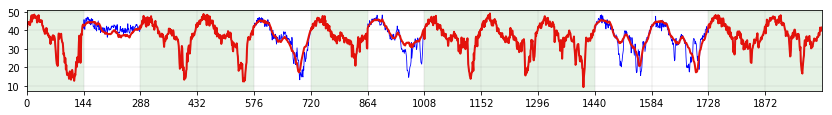

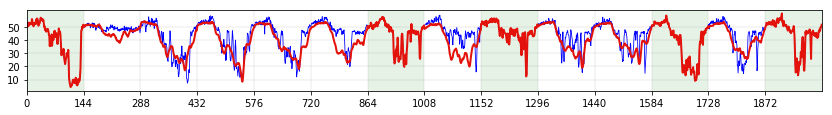

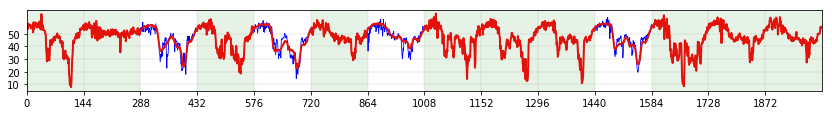

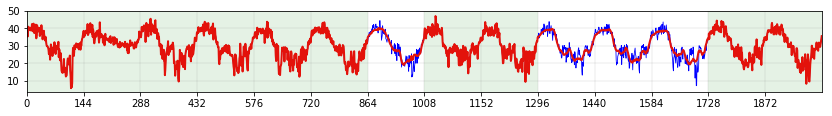

In [28]:
import matplotlib.patches as patches

day = 14

for road_id in [0, 1, 2, 3]:
    fig = plt.figure(figsize=(12, 1.5))
    ax = fig.add_axes([0.05,0.22,0.92,0.75])
    plt.plot(ten2mat(dense_tensor, 0)[road_id, : day * 144], color = "blue", 
             linewidth = 0.8, label = "Actual value")
    plt.plot(ten2mat(tensor_hat, 0)[road_id, : day * 144], color = "#e3120b", 
             linewidth = 2.0, label = "Estimated value")
    ax.set_xlim([0, day * 144 - 1])
    if i == 0:
        plt.yticks(np.arange(0, 50 + 1, 20))
    elif i == 1:
        plt.yticks(np.arange(0, 70 + 1, 20))
    elif i == 2:
        plt.yticks(np.arange(10, 70 + 1, 20))
    elif i == 3:
        plt.yticks(np.arange(10, 50 + 1, 20))
    ax.grid(color='gray', linestyle='-', linewidth=0.4, alpha=0.4)

    for i in range(day):
        if ten2mat(sparse_tensor, 0)[road_id, 144 * i] != 0:
            someX, someY = i * 144, 0
            currentAxis = plt.gca()
            ax.add_patch(patches.Rectangle((someX, someY), 144, 70, alpha = 0.1, facecolor = 'green'))

    plt.xticks(np.arange(0, day * 144, step = 144))
    plt.yticks(np.arange(10, 60, 10), [10, 20, 30, 40, 50, 60])
    plt.show()
    fig.savefig("../images/G{}_imputation_time_series_40NM.pdf".format(road_id + 1))

> The imputation performance of LATC-imputer, where the estimated result of road segment `road_id` is selected as an example. In the both two panels, white rectangles represent fiber missing (i.e., speed observations are lost in a whole day), and green rectangles indicate partially observed data.

### Results

<div class="alert alert-block alert-success">
<b>LATC-imputer</b>: Imputation performance on <b>Guangzhou traffic speed data set</b>.
</div>

<table>
<tr>
    <th></th> <th>20%, RM</th> <th>40%, RM</th> <th>20%, NM</th> <th>40%, NM</th>
</tr>
<tr>
    <td><code>rho</code></td> <td>0.0001</td> <td>0.0001</td> <td>0.0001</td> <td>0.0001</td>
</tr>
<tr>
    <td><code>lambda0</code></td> <td><code>5*rho</code></td> <td><code>5*rho</code></td> <td><code>5*rho</code></td> <td><code>5*rho</code></td>
</tr>
<tr>
    <td><code>epsilon</code></td> <td>0.01</td> <td>0.01</td> <td>0.01</td> <td>0.01</td>
</tr>
<tr>
    <td>Stop <code>maxiter</code></td> <td>12</td> <td>14</td> <td>13</td> <td>24</td>
</tr>
<tr>
    <td>MAPE</td> <td>6.98</td> <td>7.58</td> <td>10.24</td> <td>10.82</td>
</tr>
<tr>
    <td>RMSE</td> <td>2.92</td> <td>3.16</td> <td>4.17</td> <td>4.40</td>
</tr>
</table>


### Birmingham data

In [18]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/tensor.mat')
dense_tensor = tensor['tensor']
random_tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

missing_rate = 0.1

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
# =============================================================================

sparse_tensor = np.multiply(dense_tensor, binary_tensor)

In [21]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/tensor.mat')
dense_tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Birmingham-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']

missing_rate = 0.3

# =============================================================================
### Non-random missing (NM) scenario
### Set the RM scenario by:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
# =============================================================================

sparse_tensor = np.multiply(dense_tensor, binary_tensor)

In [23]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 16, 17, 18, 19, 20, 21])
alpha = np.ones(3) / 3
rho = 1e-5
lambdas = [0, 0.1, 0.5, 1, 5, 10]
epsilon = 1e-4
maxiter = 100
ps = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
thetas = [0, 5, 10, 15]
for lambda0 in lambdas:
    for p in ps:
        for theta in thetas:
            print('lambda0:')
            print(lambda0)
            print('p:')
            print(p)
            print('theta:')
            print(theta)
            tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, 
                                 alpha, rho, lambda0 * rho, p, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

lambda0:
0
p:
0.8
theta:
0
Iter: 100
Tolerance: 0.000100456
MAPE: 0.151503
RMSE: 133.888

Total iteration: 100
Tolerance: 0.000100456
Imputation MAPE: 0.151503
Imputation RMSE: 133.888

lambda0:
0
p:
0.8
theta:
5
Total iteration: 82
Tolerance: 9.70603e-05
Imputation MAPE: 0.222509
Imputation RMSE: 447.828

lambda0:
0
p:
0.8
theta:
10
Iter: 100
Tolerance: 0.000324437
MAPE: 0.780383
RMSE: 474.562

Total iteration: 100
Tolerance: 0.000324437
Imputation MAPE: 0.780383
Imputation RMSE: 474.562

lambda0:
0
p:
0.8
theta:
15
Iter: 100
Tolerance: 0.000477282
MAPE: 1.69457
RMSE: 505.611

Total iteration: 100
Tolerance: 0.000477282
Imputation MAPE: 1.69457
Imputation RMSE: 505.611

lambda0:
0
p:
0.9
theta:
0
Total iteration: 74
Tolerance: 9.69213e-05
Imputation MAPE: 0.133915
Imputation RMSE: 69.2121

lambda0:
0
p:
0.9
theta:
5
Total iteration: 78
Tolerance: 9.73417e-05
Imputation MAPE: 0.152391
Imputation RMSE: 331.721

lambda0:
0
p:
0.9
theta:
10
Iter: 100
Tolerance: 0.000726756
MAPE: 0.207975


Total iteration: 77
Tolerance: 9.40002e-05
Imputation MAPE: 0.183128
Imputation RMSE: 109.648

lambda0:
5
p:
0.9
theta:
10
Iter: 100
Tolerance: 0.000752873
MAPE: 0.181403
RMSE: 116.467

Total iteration: 100
Tolerance: 0.000752873
Imputation MAPE: 0.181403
Imputation RMSE: 116.467

lambda0:
5
p:
0.9
theta:
15
Iter: 100
Tolerance: 0.00129379
MAPE: 0.184562
RMSE: 122.986

Total iteration: 100
Tolerance: 0.00129379
Imputation MAPE: 0.184562
Imputation RMSE: 122.986

lambda0:
5
p:
1
theta:
0
Total iteration: 59
Tolerance: 9.43554e-05
Imputation MAPE: 0.17195
Imputation RMSE: 103.398

lambda0:
5
p:
1
theta:
5
Total iteration: 91
Tolerance: 6.1311e-05
Imputation MAPE: 0.153869
Imputation RMSE: 92.936

lambda0:
5
p:
1
theta:
10
Iter: 100
Tolerance: 0.00247758
MAPE: 0.14885
RMSE: 98.9091

Total iteration: 100
Tolerance: 0.00247758
Imputation MAPE: 0.14885
Imputation RMSE: 98.9091

lambda0:
5
p:
1
theta:
15
Iter: 100
Tolerance: 0.00308567
MAPE: 0.153679
RMSE: 113.06

Total iteration: 100
Toleran

### Hangzhou data

In [13]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
dense_tensor = tensor['tensor']
random_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
# =============================================================================

sparse_tensor = np.multiply(dense_tensor, binary_tensor)

In [15]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 106, 107, 108, 109, 110, 111])
alpha = np.ones(3) / 3
rho = 1e-5
lambdas = [0, 0.1, 0.5, 1, 5, 10]
epsilon = 1e-4
maxiter = 100
ps = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
thetas = [0, 5, 10, 15]
for lambda0 in lambdas:
    for p in ps:
        for theta in thetas:
            print('lambda0:')
            print(lambda0)
            print('p:')
            print(p)
            print('theta:')
            print(theta)
            tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, 
                                 alpha, rho, lambda0 * rho, p, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

lambda0:
0
p:
0.5
theta:
0
Iter: 100
Tolerance: 0.000120612
MAPE: 0.892515
RMSE: 99.8169

Total iteration: 100
Tolerance: 0.000120612
Imputation MAPE: 0.892515
Imputation RMSE: 99.8169

lambda0:
0
p:
0.5
theta:
5
Iter: 100
Tolerance: 0.00012246
MAPE: 0.90799
RMSE: 102.051

Total iteration: 100
Tolerance: 0.00012246
Imputation MAPE: 0.90799
Imputation RMSE: 102.051

lambda0:
0
p:
0.5
theta:
10
Iter: 100
Tolerance: 0.000115739
MAPE: 0.973326
RMSE: 110.137

Total iteration: 100
Tolerance: 0.000115739
Imputation MAPE: 0.973326
Imputation RMSE: 110.137

lambda0:
0
p:
0.5
theta:
15
Iter: 100
Tolerance: 0.000108352
MAPE: 1.05216
RMSE: 118.418

Total iteration: 100
Tolerance: 0.000108352
Imputation MAPE: 1.05216
Imputation RMSE: 118.418

lambda0:
0
p:
0.6
theta:
0
Iter: 100
Tolerance: 0.000101141
MAPE: 0.241943
RMSE: 47.6607

Total iteration: 100
Tolerance: 0.000101141
Imputation MAPE: 0.241943
Imputation RMSE: 47.6607

lambda0:
0
p:
0.6
theta:
5
Iter: 100
Tolerance: 0.000101217
MAPE: 0.252089

Total iteration: 61
Tolerance: 9.54737e-05
Imputation MAPE: 0.203131
Imputation RMSE: 42.4359

lambda0:
0.5
p:
0.7
theta:
10
Total iteration: 79
Tolerance: 8.16294e-05
Imputation MAPE: 0.20426
Imputation RMSE: 44.7277

lambda0:
0.5
p:
0.7
theta:
15
Total iteration: 98
Tolerance: 9.91937e-05
Imputation MAPE: 0.209972
Imputation RMSE: 47.065

lambda0:
0.5
p:
0.8
theta:
0
Total iteration: 61
Tolerance: 9.92254e-05
Imputation MAPE: 0.194082
Imputation RMSE: 37.1557

lambda0:
0.5
p:
0.8
theta:
5
Total iteration: 72
Tolerance: 9.58775e-05
Imputation MAPE: 0.192935
Imputation RMSE: 35.2793

lambda0:
0.5
p:
0.8
theta:
10
Total iteration: 84
Tolerance: 9.94095e-05
Imputation MAPE: 0.192352
Imputation RMSE: 40.3325

lambda0:
0.5
p:
0.8
theta:
15
Iter: 100
Tolerance: 0.000229366
MAPE: 0.197054
RMSE: 41.9462

Total iteration: 100
Tolerance: 0.000229366
Imputation MAPE: 0.197054
Imputation RMSE: 41.9462

lambda0:
0.5
p:
0.9
theta:
0
Total iteration: 51
Tolerance: 9.84247e-05
Imputation MAPE: 0.1910

Iter: 100
Tolerance: 0.000607463
MAPE: 0.20038
RMSE: 39.4103

Total iteration: 100
Tolerance: 0.000607463
Imputation MAPE: 0.20038
Imputation RMSE: 39.4103

lambda0:
5
p:
1
theta:
10
Iter: 100
Tolerance: 0.0034346
MAPE: 0.199295
RMSE: 43.0662

Total iteration: 100
Tolerance: 0.0034346
Imputation MAPE: 0.199295
Imputation RMSE: 43.0662

lambda0:
5
p:
1
theta:
15
Iter: 100
Tolerance: 0.00542821
MAPE: 0.203885
RMSE: 45.1985

Total iteration: 100
Tolerance: 0.00542821
Imputation MAPE: 0.203885
Imputation RMSE: 45.1985

lambda0:
10
p:
0.5
theta:
0
Total iteration: 65
Tolerance: 8.01087e-05
Imputation MAPE: 0.322407
Imputation RMSE: 66.9619

lambda0:
10
p:
0.5
theta:
5
Total iteration: 65
Tolerance: 8.22597e-05
Imputation MAPE: 0.323179
Imputation RMSE: 66.9649

lambda0:
10
p:
0.5
theta:
10
Total iteration: 65
Tolerance: 8.62404e-05
Imputation MAPE: 0.324324
Imputation RMSE: 67.0175

lambda0:
10
p:
0.5
theta:
15
Total iteration: 65
Tolerance: 9.40565e-05
Imputation MAPE: 0.327201
Imputation 

### Seattle data

In [16]:
import pandas as pd

dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0)
RM_mat = pd.read_csv('../datasets/Seattle-data-set/RM_mat.csv', index_col = 0)
dense_mat = dense_mat.values
RM_mat = RM_mat.values
dense_tensor = dense_mat.reshape([dense_mat.shape[0], 28, 288])
RM_tensor = RM_mat.reshape([RM_mat.shape[0], 28, 288])

missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_tensor = np.round(RM_tensor + 0.5 - missing_rate)
# =============================================================================

sparse_tensor = np.multiply(dense_tensor, binary_tensor)

In [17]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
alpha = np.ones(3) / 3
rho = 1e-5
lambdas = [0, 0.1, 0.5, 1, 5, 10]
epsilon = 1e-4
maxiter = 100
ps = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
thetas = [0, 5, 10, 15, 20]
for lambda0 in lambdas:
    for p in ps:
        for theta in thetas:
            print('lambda0:')
            print(lambda0)
            print('p:')
            print(p)
            print('theta:')
            print(theta)
            tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, 
                                 alpha, rho, lambda0 * rho, p, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

lambda0:
0
p:
0.5
theta:
0
Total iteration: 44
Tolerance: 9.92174e-05
Imputation MAPE: 0.0546074
Imputation RMSE: 3.36464

lambda0:
0
p:
0.5
theta:
5
Total iteration: 41
Tolerance: 9.93372e-05
Imputation MAPE: 0.053585
Imputation RMSE: 3.35015

lambda0:
0
p:
0.5
theta:
10
Total iteration: 47
Tolerance: 9.75991e-05
Imputation MAPE: 0.0520729
Imputation RMSE: 3.29686

lambda0:
0
p:
0.5
theta:
15
Total iteration: 61
Tolerance: 9.95574e-05
Imputation MAPE: 0.0506884
Imputation RMSE: 3.24298

lambda0:
0
p:
0.5
theta:
20
Total iteration: 54
Tolerance: 9.31677e-05
Imputation MAPE: 0.0500588
Imputation RMSE: 3.21961

lambda0:
0
p:
0.6
theta:
0
Total iteration: 49
Tolerance: 9.89347e-05
Imputation MAPE: 0.0568866
Imputation RMSE: 3.45047

lambda0:
0
p:
0.6
theta:
5
Total iteration: 43
Tolerance: 9.88756e-05
Imputation MAPE: 0.0554809
Imputation RMSE: 3.43274

lambda0:
0
p:
0.6
theta:
10
Total iteration: 65
Tolerance: 9.30524e-05
Imputation MAPE: 0.0528471
Imputation RMSE: 3.33098

lambda0:
0
p:

Iter: 100
Tolerance: 0.006948
MAPE: 0.0550903
RMSE: 3.44691

Total iteration: 100
Tolerance: 0.006948
Imputation MAPE: 0.0550903
Imputation RMSE: 3.44691

lambda0:
0.1
p:
1
theta:
20
Iter: 100
Tolerance: 0.00806671
MAPE: 0.0532106
RMSE: 3.36496

Total iteration: 100
Tolerance: 0.00806671
Imputation MAPE: 0.0532106
Imputation RMSE: 3.36496

lambda0:
0.5
p:
0.5
theta:
0


KeyboardInterrupt: 

### PeMS data

In [150]:
dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
random_tensor = np.load('../datasets/PeMS-data-set/random_tensor.npy')

missing_rate = 0.4

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, ten2mat(binary_tensor, 0))

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

In [151]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 5 * rho
epsilon = 1e-4
maxiter = 100
theta = 15
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, epsilon, maxiter, theta)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 97
Tolerance: 9.29503e-05
Imputation MAPE: 0.0350057
Imputation RMSE: 2.5372

Running time: 127 seconds


In [20]:
dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
random_matrix = np.load('../datasets/PeMS-data-set/random_matrix.npy')

missing_rate = 0.4

### Nonrandom missing (NM) scenario:
binary_tensor = np.zeros((dense_mat.shape[0], 288, 44))
for i1 in range(dense_mat.shape[0]):
    for i2 in range(44):
        binary_tensor[i1,:,i2] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = ten2mat(binary_tensor, 0)
sparse_mat = np.multiply(dense_mat, binary_mat)

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

In [22]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 1 * rho
epsilon = 1e-4
maxiter = 100
theta = 10
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 77
Tolerance: 7.96771e-05
Imputation MAPE: 0.0778101
Imputation RMSE: 5.46434

Running time: 105 seconds


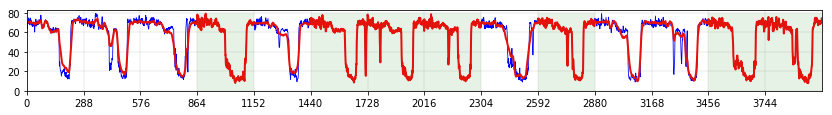

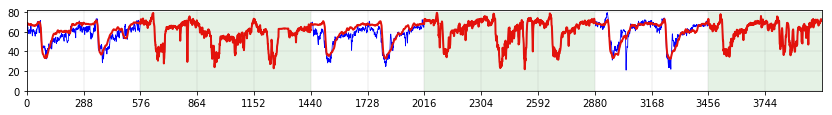

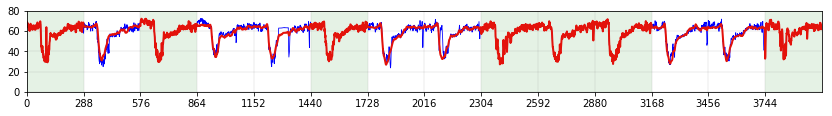

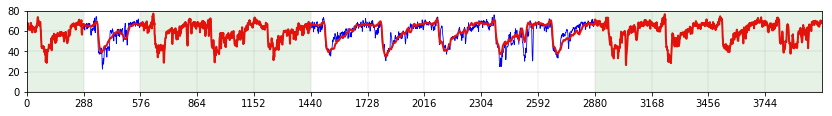

In [25]:
import matplotlib.patches as patches

day = 14

for road_id in [1, 2, 3, 4]:
    fig = plt.figure(figsize=(12, 1.5))
    ax = fig.add_axes([0.05,0.22,0.92,0.75])
    plt.plot(ten2mat(dense_tensor, 0)[road_id, : day * 288], color = "blue", 
             linewidth = 0.8, label = "Actual value")
    plt.plot(ten2mat(tensor_hat, 0)[road_id, : day * 288], color = "#e3120b", 
             linewidth = 2.0, label = "Estimated value")
    ax.set_xlim([0, day * 288 - 1])
    ax.grid(color='gray', linestyle='-', linewidth=0.4, alpha=0.4)

    for i in range(day):
        if ten2mat(sparse_tensor, 0)[road_id, 288 * i] != 0:
            someX, someY = i * 288, 0
            currentAxis = plt.gca()
            ax.add_patch(patches.Rectangle((someX, someY), 288, 80, alpha = 0.1, facecolor = 'green'))

    plt.xticks(np.arange(0, day * 288, step = 288))
    plt.yticks(np.arange(0, 80 + 1, 20))
    plt.show()
    fig.savefig("../images/P{}_imputation_time_series_40NM.pdf".format(road_id + 1))

### Electricity data

- **Random Missing (RM)**:

In [53]:
dense_mat = np.load('../datasets/Electricity-data-set/electricity35.npy')
random_tensor = np.load('../datasets/Electricity-data-set/random_tensor.npy')

missing_rate = 0.2

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, ten2mat(binary_tensor, 0))

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

- **Nonrandom Missing (NM)**:

In [29]:
dense_mat = np.load('../datasets/Electricity-data-set/electricity35.npy')
random_matrix = np.load('../datasets/Electricity-data-set/random_matrix.npy')

missing_rate = 0.4

### Nonrandom missing (NM) scenario:
binary_tensor = np.zeros((dense_mat.shape[0], 24, 35))
for i1 in range(dense_mat.shape[0]):
    for i2 in range(35):
        binary_tensor[i1,:,i2] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = ten2mat(binary_tensor, 0)
sparse_mat = np.multiply(dense_mat, binary_mat)

sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

- **Cross validation**

In [40]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 22, 23, 24, 25, 26, 27])
alpha = np.ones(3) / 3
rho = 1
lambdas = rho * np.array([0.5, 1, 5, 10])
epsilon = 1e-4
maxiter = 100
thetas = np.array([5, 10, 15])
validation_rate = 0.05
num_fold = 3

train_data, validation_data = imputer_validation(sparse_tensor, validation_rate, num_fold)
result = cross_validation(train_data, validation_data, num_fold, lambdas, thetas,
                          time_lags, alpha, rho, epsilon, maxiter)
print('Cross Validation MAPE:')
print(result[:, :, 0])
print()
print('Cross Validation RMSE:')
print(result[:, :, 1])
print()
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 100
Tolerance: 0.000110912
Imputation MAPE: 0.14795
Imputation RMSE: 0.00319108

Total iteration: 100
Tolerance: 0.00011376
Imputation MAPE: 0.181986
Imputation RMSE: 0.00494463

Total iteration: 100
Tolerance: 0.000118957
Imputation MAPE: 0.128743
Imputation RMSE: 0.00416884

Total iteration: 100
Tolerance: 0.000167513
Imputation MAPE: 0.154308
Imputation RMSE: 0.00395715

Total iteration: 100
Tolerance: 0.000168087
Imputation MAPE: 0.17663
Imputation RMSE: 0.00590011

Total iteration: 100
Tolerance: 0.000177089
Imputation MAPE: 0.149195
Imputation RMSE: 0.00525643

Total iteration: 100
Tolerance: 0.000183029
Imputation MAPE: 0.152121
Imputation RMSE: 0.00492307

Total iteration: 100
Tolerance: 0.000190319
Imputation MAPE: 0.173663
Imputation RMSE: 0.00694149

Total iteration: 100
Tolerance: 0.000200668
Imputation MAPE: 0.157633
Imputation RMSE: 0.00664106

Total iteration: 100
Tolerance: 0.00021639
Imputation MAPE: 0.143248
Imputation RMSE: 0.00415998

Total iteratio

- **Find best parameters**

In [41]:
print('Best lambda:')
pos = np.where(result[:, :, 0] == np.min(result[:, :, 0]))
print(lambdas[pos[0]] / rho)
print()
print('Best theta:')
print(thetas[pos[1]])

Best lambda:
[10.]

Best theta:
[15]


- **Make imputation**

In [30]:
import time
start = time.time()
time_lags = np.array([1, 2, 3, 4, 5, 6, 22, 23, 24, 25, 26, 27])
alpha = np.ones(3) / 3
rho = 1e-6
lambda0 = 5 * rho
epsilon = 1e-4
maxiter = 100
theta = 1
tensor_hat = imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Total iteration: 76
Tolerance: 9.65526e-05
Imputation MAPE: 0.154994
Imputation RMSE: 1026.03

Running time: 10 seconds


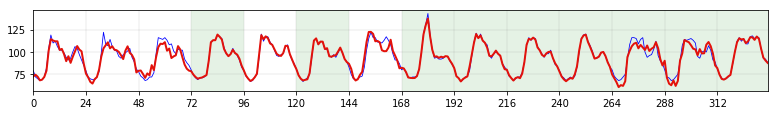

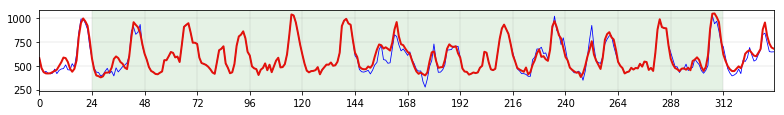

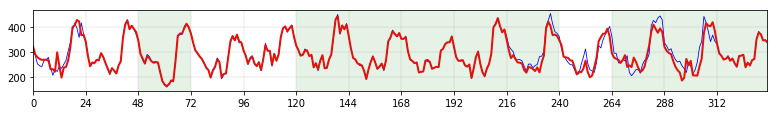

In [34]:
import matplotlib.patches as patches

day = 14

for client in [1, 3, 4]:
    fig = plt.figure(figsize=(12, 1.5))
    ax = fig.add_axes([0.10,0.22,0.85,0.75])
    plt.plot(ten2mat(dense_tensor, 0)[client, - day * 24 :], color = "blue", 
             linewidth = 0.8, label = "Actual value")
    plt.plot(ten2mat(tensor_hat, 0)[client, - day * 24 :], color = "#e3120b", 
             linewidth = 2.0, label = "Estimated value")
    ax.set_xlim([0, day * 24 - 1])
    # ax.set_ylim([0, 60])
    ax.grid(color='gray', linestyle='-', linewidth=0.4, alpha=0.4)

    for i in range(day):
        if ten2mat(sparse_tensor, 0)[client, 24 * i] != 0:
            someX, someY = i * 24, 0
            currentAxis = plt.gca()
            ax.add_patch(patches.Rectangle((someX, someY), 24, 5000, alpha = 0.1, facecolor = 'green'))
            
    plt.xticks(np.arange(0, day * 24, step = 24))
    if i == 1:
        plt.yticks(np.arange(60, 140 + 1, 20))
    elif i == 3:
        plt.yticks(np.arange(300, 1100 + 1, 200))
    elif i == 4:
        plt.yticks(np.arange(150, 600 + 1, 100))
    plt.show()
    fig.savefig("../images/E{}_imputation_time_series_40NM.pdf".format(client + 1))

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>